<h3>  Imports </h3>

In [6]:
import numpy as np
import math
import matplotlib.cm as cm 
import matplotlib.pyplot as plt

# Fetching datasets 

In [12]:
datasets_path = "/Users/31_grudnia/Desktop/Python/Playground/Masters_Degree_Project/backend/MNIST_app/MNIST_utils_files/signs_with_labels/"

# Train datasets
X_train: np.ndarray = np.load(datasets_path + "X_train.npy")
Y_train: np.ndarray = np.load(datasets_path + "Y_train.npy")

In [13]:
# Test datasets
X_test: np.ndarray = np.load(datasets_path + "X_test.npy")
Y_test: np.ndarray = np.load(datasets_path + "Y_test.npy")

In [14]:
# Validation datasets
X_val: np.ndarray = np.load(datasets_path + "X_val.npy")
Y_val: np.ndarray = np.load(datasets_path + "Y_val.npy")

# One Hot Encoder

In [7]:
def one_hot_encode(Y_data: np.ndarray):
    
    categories: np.ndarray = sorted(list(set(Y_data)))
    one_hot_encoded_data: np.ndarray = []
    
    row: np.ndarray = np.zeros(shape=(len(categories),), dtype=int)
    print(row)
    for index in range(len(Y_data)):
        
        pass
    # for item in X_data:
    #     row = [0] * len(categories)
        
    #     # Mark `1` for the corresponding category
    #     row[categories.index(item)] = 1
    #     one_hot_encoded_data.append(row)
    
    # return one_hot_encoded_data, categories


Y_train_test = Y_train.copy()
# X_train_test = X_train.copy() 
one_hot_encode(Y_data=Y_train_test)

NameError: name 'Y_train' is not defined

# Tests

In [15]:
print(X_train.shape, Y_train.shape)

(446524, 32, 32) (446524,)


(446524,)
(446524, 32, 32)


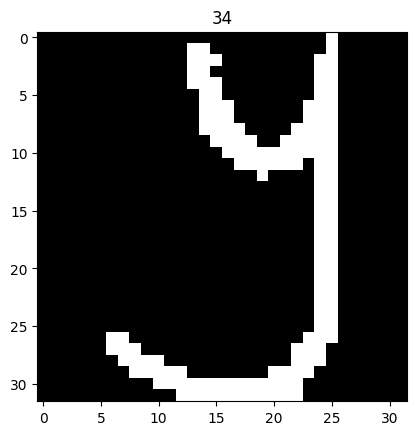

In [16]:
print(Y_train.shape)
print(X_train.shape)
index=7;
plt.title((Y_train[index]))
plt.imshow(X_train[index].reshape(32, 32), cmap=cm.binary)